# SPAM DETECTION SYSTEM

This project aims to build a spam detection system using Natural Language Processing (NLP) techniques in order to classify emails as spam or not spam based on the content of the email.
The steps involved in this project are:
1. Train a classifier to identify spam emails.
2. Find out the principal topics of the spam emails.
3. Compute the semantic similarity between the spam emails, to verify the etheroegeneity of the spam emails.
4. Extract from non-spam emails the Organisations mentioned in the emails.

In [1]:
import pandas as pd
import numpy as np
import models as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi=False

2024-07-01 20:12:46.340820: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-01 20:12:46.342530: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-01 20:12:46.367013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-01 20:12:46.367036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-01 20:12:46.367711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

The dataset is available in data, and it is called `spam_dataset.csv`. It contains the following columns:

In [2]:
spam_df = pd.read_csv('../data/spam_dataset.csv', index_col=0)
spam_df.head(5)
print('------------------')
spam_df.shape
print('------------------')
spam_df.isnull().sum()
print('------------------')
spam_df['text'][605]
print('------------------')
spam_df.value_counts('label')

,label,text,label_num
605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
4685,spam,"Subject: photoshop , windows , office . cheap ...",1
2030,ham,Subject: re : indian springs\nthis deal is to ...,0


------------------


(5171, 3)

------------------


label        0
text         0
label_num    0
dtype: int64

------------------


"Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\nflow data provided by daren } .\nplease override pop ' s daily volume { presently zero } to reflect daily\nactivity you can obtain from gas control .\nthis change is needed asap for economics purposes ."

------------------


label
ham     3672
spam    1499
Name: count, dtype: int64

In [3]:
spam_df.reset_index(drop=True, inplace=True)
spam_df.head(3)

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0


In [4]:
import nltk
import spacy
import os

try:
    nlp = spacy.load('en_core_web_sm')
except:
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')
try:
    eng_stopwords = nltk.corpus.stopwords.words('english')
except:
    nltk.download('stopwords')
    eng_stopwords = nltk.corpus.stopwords.words('english')
try:
    _ = nltk.tokenize.word_tokenize('test')
except:
    nltk.download('punkt')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 8.9 MB/s eta 0:00:00m eta 0:00:010:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


0

In [5]:
np.argmax([len(spam_df['text'][i]) for i in range(spam_df.shape[0])])

949

In [6]:
emails = spam_df['text'].values

In [7]:
def preprocess_text_and_store(text, doc_store=None, store=False):
    preprocessed_text = np.empty(len(text), dtype=object)
    if doc_store is None or doc_store not in os.listdir('../data'):
        counter = 0
        for i in range(len(text)):
            process_words = []
            text[i] = text[i].replace('\d', ' ')
            for word in nltk.word_tokenize(nlp(text[i].lower()).text):
                if word.isalpha() and word not in eng_stopwords and len(str(word)):# >= 3:
                    process_words.append(word)
            preprocessed_text[counter] = ' '.join(process_words)
            counter += 1
    else:
        preprocessed_text = np.array(pd.read_csv('../data/'+doc_store)['comment_text'])
    if store:
        pd.DataFrame(data = {"comment_text":preprocessed_text}).to_csv('../data/'+doc_store)

    return preprocessed_text

In [8]:
preprocessed_text= preprocess_text_and_store(emails, doc_store="preprocessed_spam_df.csv", store=True)

In [9]:
from sklearn.model_selection import train_test_split

def train_test_val_split(data, labels=None, test_size=0.2, val_size=0.1, random_state=42):
    if labels is None:
        data, labels = data
    corpus, X_test, train_labels, y_test = train_test_split(data, labels, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(corpus, train_labels, test_size=val_size/(1-test_size), random_state=random_state)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    y_val = np.array(y_val)

    return X_train.astype(str).tolist(), X_test.astype(str).tolist(), X_val.astype(str).tolist(), y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(preprocessed_text, labels=spam_df['label_num'], test_size=0.2, val_size=0.15)


X_train[0:3]
y_train[0:3]

['subject dobmeos hgh energy level gone stukm introducing doctor formulated hgh human growth hormone also called hgh referred medical science master hormone plentiful young near age twenty one bodies begin produce less time forty nearly everyone deficient hgh eighty production normally diminished least advantages hgh increased muscle strength loss body fat increased bone density lower blood pressure quickens wound healing reduces cellulite improved vision wrinkle disappearance increased skin thickness texture increased energy levels improved sleep emotional stability improved memory mental alertness increased sexual potency resistance common illness strengthened heart muscle controlled cholesterol controlled mood swings new hair growth color restore read website unsubscribe',
 'subject',
 'subject enron actuals dec dec teco tap enron hpl gas daily lsp hpl katy c enron']

array([1, 1, 0])

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(X_train)

tokenizer.word_counts

OrderedDict([('subject', 5154),
             ('dobmeos', 1),
             ('hgh', 10),
             ('energy', 498),
             ('level', 63),
             ('gone', 23),
             ('stukm', 1),
             ('introducing', 8),
             ('doctor', 47),
             ('formulated', 4),
             ('human', 18),
             ('growth', 77),
             ('hormone', 7),
             ('also', 484),
             ('called', 112),
             ('referred', 5),
             ('medical', 53),
             ('science', 8),
             ('master', 25),
             ('plentiful', 1),
             ('young', 161),
             ('near', 46),
             ('age', 48),
             ('twenty', 15),
             ('one', 576),
             ('bodies', 5),
             ('begin', 67),
             ('produce', 12),
             ('less', 225),
             ('time', 628),
             ('forty', 8),
             ('nearly', 14),
             ('everyone', 95),
             ('deficient', 1),
             ('e

In [11]:
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_val_padded = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)

Vocabulary size:  36003


In [12]:
maxlen = len(max(X_train_padded, key=len))
X_train_padded = pad_sequences(X_train_padded, padding='pre', maxlen=maxlen)
X_test_padded = pad_sequences(X_test_padded, padding='pre', maxlen=maxlen)
X_val_padded = pad_sequences(X_val_padded, padding='pre', maxlen=maxlen)

In [13]:
X_train_padded[0:5]
X_train_padded.shape
y_train.shape

array([[   0,    0,    0, ...,  409,  508,  576],
       [   0,    0,    0, ...,    0,    0,    2],
       [   0,    0,    0, ...,  556,   68,    4],
       [   0,    0,    0, ..., 1450,  288,   37],
       [   0,    0,    0, ...,  385,  648,  197]], dtype=int32)

(3360, 1725)

(3360,)

In [14]:
import tensorflow as tf
early_stopping = md.EarlyStopping(5)

In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.backend import clear_session

def CNN_model(vocab_size, maxlen, activation='softmax'):
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim=256, input_length=maxlen))
    model.add(GRU(units=128))
    model.add(Dense(1, activation=activation))
    return model


In [16]:
w0 = [(1/np.sum(y_train == 0)) * (len(y_train) /2)]
w1 = [(1/np.sum(y_train == 1)) * (len(y_train) /2)] 
w0, w1
clear_session()
@tf.keras.saving.register_keras_serializable()#senza specificare un paramentro, sovvrascrive loss
def weighted_binary_crossentropy(w0, w1):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        _w0 = tf.constant(w0, dtype=tf.float32)
        _w1 = tf.constant(w1, dtype=tf.float32)
        loss = -_w0 * y_true * tf.math.log(y_pred) - _w1 * (1 - y_true) * tf.math.log(1 - y_pred)
        return tf.reduce_mean(loss)
    return loss

lstm_cnn_model_keras = "lstm_cnn_model.keras"
custom_objects = {'loss': md.weighted_binary_crossentropy(w0, w1)}
transfer_learning_model = load_model("../models/"+lstm_cnn_model_keras, custom_objects=custom_objects, )

([0.7055858882822343], [1.7160367722165475])

In [17]:
transfer_learning_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 bidirectional (Bidirection  (None, 1250, 200)         200800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1250, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, 1246, 64)          64064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                        

In [18]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
new_input = Input(shape=(maxlen,))

In [19]:
transfer_learning_model.summary()
output = transfer_learning_model.layers[0](new_input)
for i in range(1, len(transfer_learning_model.layers)):
    output = transfer_learning_model.layers[i](output)
output = Dense(1, activation='sigmoid', name='output')(output)
lstm_cnn_model = Model(new_input, output)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 150)         13954350  
                                                                 
 dropout (Dropout)           (None, 1250, 150)         0         
                                                                 
 bidirectional (Bidirection  (None, 1250, 200)         200800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1250, 200)         0         
                                                                 
 conv1d (Conv1D)             (None, 1246, 64)          64064     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                        

In [20]:
lstm_cnn_model.compile(optimizer='adam', loss=md.weighted_binary_crossentropy(w0, w1), metrics=['accuracy'])
lstm_cnn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1725)]            0         
                                                                 
 embedding (Embedding)       multiple                  13954350  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 bidirectional (Bidirection  multiple                  200800    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 conv1d (Conv1D)             multiple                  64064     
                                                             

In [21]:
history = lstm_cnn_model.fit(X_train_padded, 
                        y_train, 
                        epochs=10, 
                        validation_data=(X_val_padded, y_val), 
                        batch_size=32, 
                        callbacks=[early_stopping])

Epoch 1/10
105/105 [==============================] - 139s 1s/step - loss: 0.9665 - accuracy: 0.7039 - val_loss: 0.9347 - val_accuracy: 0.7255
Epoch 2/10
105/105 [==============================] - 143s 1s/step - loss: 0.8588 - accuracy: 0.7342 - val_loss: 0.7468 - val_accuracy: 0.7332
Epoch 3/10
105/105 [==============================] - 143s 1s/step - loss: 0.6970 - accuracy: 0.7750 - val_loss: 0.6470 - val_accuracy: 0.7912
Epoch 4/10
105/105 [==============================] - 139s 1s/step - loss: 0.5745 - accuracy: 0.8750 - val_loss: 0.5078 - val_accuracy: 0.9085
Epoch 5/10
105/105 [==============================] - 139s 1s/step - loss: 0.4653 - accuracy: 0.9339 - val_loss: 0.4446 - val_accuracy: 0.9201
Epoch 6/10
105/105 [==============================] - 143s 1s/step - loss: 0.3867 - accuracy: 0.9595 - val_loss: 0.3711 - val_accuracy: 0.9588
Epoch 7/10
105/105 [==============================] - 142s 1s/step - loss: 0.3273 - accuracy: 0.9747 - val_loss: 0.3286 - val_accuracy: 0.9562

In [22]:
clear_session()
cnn_model = CNN_model(vocab_size=vocab_size, maxlen=maxlen, activation='sigmoid')

In [23]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1725, 256)         9216768   
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9365121 (35.73 MB)
Trainable params: 9365121 (35.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_padded, 
                        y_train, 
                        epochs=10, 
                        validation_data=(X_val_padded, y_val), 
                        batch_size=32, 
                        callbacks=[early_stopping])

Epoch 1/10
105/105 [==============================] - 97s 917ms/step - loss: 0.2259 - accuracy: 0.8997 - val_loss: 0.1068 - val_accuracy: 0.9588
Epoch 2/10
105/105 [==============================] - 93s 891ms/step - loss: 0.0704 - accuracy: 0.9804 - val_loss: 0.1035 - val_accuracy: 0.9652
Epoch 3/10
105/105 [==============================] - 92s 873ms/step - loss: 0.0331 - accuracy: 0.9902 - val_loss: 0.1012 - val_accuracy: 0.9691
Epoch 4/10
105/105 [==============================] - 93s 891ms/step - loss: 0.0414 - accuracy: 0.9899 - val_loss: 0.0821 - val_accuracy: 0.9755
Epoch 5/10
105/105 [==============================] - 94s 895ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.0765 - val_accuracy: 0.9820
Epoch 6/10
105/105 [==============================] - ETA: 0s - loss: 0.0066 - accuracy: 0.9982
Stop training at epoch: 6
105/105 [==============================] - 93s 884ms/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 0.0922 - val_accuracy: 0.9781


In [25]:
y_pred = cnn_model.predict(X_test_padded)

33/33 [==============================] - 8s 229ms/step


In [28]:
y_pred_cnn_lstm = lstm_cnn_model.predict(X_test_padded)

33/33 [==============================] - 14s 425ms/step


In [29]:
from sklearn.metrics import classification_report, confusion_matrix

confusion_matrix(y_test, np.round(y_pred))
confusion_matrix(y_test, np.round(y_pred_cnn_lstm))

array([[728,  14],
       [ 17, 276]])

array([[731,  11],
       [ 13, 280]])

In [45]:
y_pred_cnn_lstm = np.round(y_pred_cnn_lstm)

## Clustering of spam emails

IDEA: per individuare il numero di topics, possiamo usare l'elbow method, che consiste nel calcolare la somma dei quadrati delle distanze tra i punti e i centroidi. Questo valore viene calcolato per un numero di cluster crescente, e si sceglie il numero di cluster in cui la somma delle distanze si stabilizza.


In [26]:
type(preprocessed_text)
preprocessed_text[1]

numpy.ndarray

'subject hpl nom january see attached file hplnol xls hplnol xls'

In [59]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def compute_inertia_with_kmeans_pp(data):
    sse = {}

    for k in range(1, 11):
        kmeans = KMeans(init="k-means++", n_clusters=k)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), marker="o")
    plt.show()

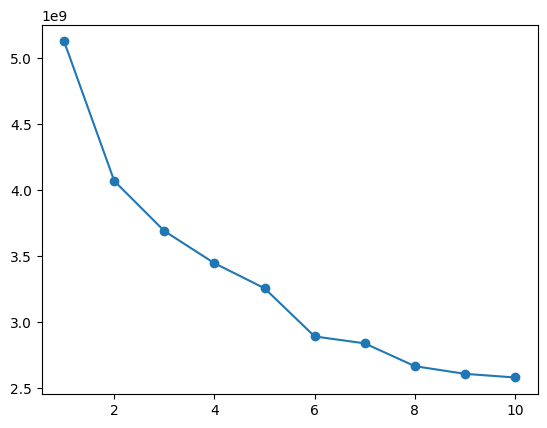

In [60]:
X_1 = [x_pad for i, x_pad in enumerate(X_test_padded) if y_pred_cnn_lstm[i] == 1]

compute_inertia_with_kmeans_pp(X_1)

In [64]:
import seaborn as sns
def plot_scatter_2D(X, L, y_kmeans, labels, centers):
    vfunc = np.vectorize(lambda x: L[x])
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=vfunc(y_kmeans), s=75) #ERRORE QUI; X[:,0] NON E' UN ARRAY DI NUMERI, BENSI UN ARRAY DI ARRAY PAROLE
    plt.scatter(centers[:,0], centers[:,1], c="red", s=150, alpha=0.5)
    
    #if print_ssd:
    #    plt.text(X[:,0].max()-10, 0, f"SSD={model.inertia_:.2f}")
    
    plt.show()

In [68]:
RANDOM_SEED = 0
n_clusters = 8
kmeans = KMeans(init="k-means++", n_clusters=8, random_state=RANDOM_SEED)
kmeans.fit(X_1)
test_cluster = kmeans.labels_
centers = kmeans.cluster_centers_
y_kmeans = kmeans.predict(X_1)
L = {x : f"Cat. {x+1}" for x in range(n_clusters)}

plot_scatter_2D(X_1, L, y_kmeans, kmeans.labels_, kmeans.cluster_centers_)

KMeans(random_state=0)

TypeError: list indices must be integers or slices, not tuple